In [3]:
!git clone https://github.com/zhanghang1989/PyTorch-Encoding

Cloning into 'PyTorch-Encoding'...
remote: Enumerating objects: 1829, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1829 (delta 33), reused 42 (delta 19), pack-reused 1752
Receiving objects: 100% (1829/1829), 21.21 MiB | 39.06 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.


In [1]:
pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4 MB 6.8 kB/s 
     |████████████████████████████████| 4.0 MB 57.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [5]:
!CC=clang CXX=clang++ pip install git+https://github.com/zhanghang1989/PyTorch-Encoding/

  Cloning https://github.com/zhanghang1989/PyTorch-Encoding/ to /tmp/pip-req-build-x36fe0z0
  Running command git clone -q https://github.com/zhanghang1989/PyTorch-Encoding/ /tmp/pip-req-build-x36fe0z0
     |████████████████████████████████| 154 kB 3.2 MB/s 
  Created wheel for torch-encoding: filename=torch_encoding-1.2.2b20220316-cp37-cp37m-linux_x86_64.whl size=3079789 sha256=a6401fd8d638615b008c1d69902a3836930641f54084843227373092e81379de
  Stored in directory: /tmp/pip-ephem-wheel-cache-6btzwa5d/wheels/d4/83/00/5a9524a23f206528125bf76110b7304681afa76adbba084b5c
Successfully built torch-encoding


In [82]:
import torch
import encoding

# Get the model
model = encoding.models.get_model('Encnet_ResNet50s_PContext', pretrained=True).cuda()
model.eval()

# Prepare the image
url = 'https://github.com/zhanghang1989/image-data/blob/master/' + \
      'encoding/segmentation/pcontext/2010_001829_org.jpg?raw=true'
filename = 'example.jpg'
img = encoding.utils.load_image(
    encoding.utils.download(url, filename)).cuda().unsqueeze(0)

# Make prediction
output = model.evaluate(img)
predict = torch.max(output, 1)[1].cpu().numpy() + 1

# Get color pallete for visualization
mask = encoding.utils.get_mask_pallete(predict, 'pascal_voc')
mask.save('output_true.png')

In [9]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=3ca5ce036602aeb575130142293dbc3aa9759a7f0e0ea94c405a540cde797aeb
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [11]:
from torchviz import make_dot

make_dot(output, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


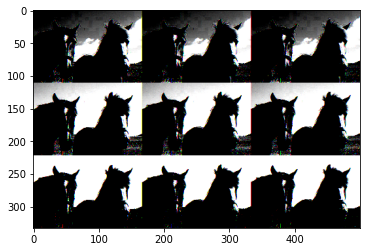

In [59]:
import matplotlib.pyplot as plt
plt.imshow(encoding.utils.load_image(
    encoding.utils.download(url, filename)).reshape(333, 500, 3))

### ResNet

In [191]:
img.size()

torch.Size([1, 3, 333, 500])

In [89]:
imsize = img.size()[2:]
features = model.base_forward(img)

In [38]:
for i in features:
  print(i.shape)

torch.Size([1, 256, 84, 125])
torch.Size([1, 512, 42, 63])
torch.Size([1, 1024, 42, 63])
torch.Size([1, 2048, 42, 63])


### EncHead

준비물: features

ResNet에서 받아온 c1, c2, c3, c4를 이용함

In [174]:
feat = model.head.conv5(features[-1])

print(feat.shape)

torch.Size([1, 512, 42, 63])


먼저 맨 마지막 conv layer을 가져다가 convolution 진행

In [175]:
c2 = model.head.connect[0](features[1])
c3 = model.head.connect[1](features[2])

feat = model.head.fusion(torch.cat([feat, c2, c3], 1))

print(c2.shape)

torch.Size([1, 512, 42, 63])


그 후 c2, c3과 같이 Conv2d, norm_layer, ReLU로 합침

### EncModule

In [176]:
model.head.encmodule

EncModule(
  (encoding): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): SyncBatchNorm(sync=False)
    (2): ReLU(inplace=True)
    (3): Encoding(N x 512=>32x512)
    (4): SyncBatchNorm(sync=False)
    (5): ReLU(inplace=True)
    (6): Mean()
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Sigmoid()
  )
  (selayer): Linear(in_features=512, out_features=59, bias=True)
)

In [177]:
# ReLU 까지
en = model.head.encmodule.encoding[:3](feat)
en.shape

torch.Size([1, 512, 42, 63])

In [178]:
"""
Encoding

Args:
    D: dimension of the features or feature channels
    K: number of codeswords

Output:
    E: output encoders, {e_1, ..., e_K}
    여기서 D = 512, k = 59
"""
# BxDxHxW => Bx(HW)xD
X = en.view(1, 512, -1).transpose(1, 2).contiguous()
X.shape

torch.Size([1, 2646, 512])

In [179]:
from encoding.functions import scaled_l2, aggregate, pairwise_cosine

# assignment weights BxNxK
A = F.softmax(scaled_l2(X, model.head.encmodule.encoding[3].codewords, model.head.encmodule.encoding[3].scale), dim=2)
# aggregate
E = aggregate(A, X, model.head.encmodule.encoding[3].codewords)

In [180]:
model.head.encmodule.encoding[3].codewords.shape, model.head.encmodule.encoding[3].scale.shape

(torch.Size([32, 512]), torch.Size([32]))

In [181]:
A.shape, E.shape

(torch.Size([1, 2646, 32]), torch.Size([1, 32, 512]))

In [182]:
# .mean() 까지 마무리
en = model.head.encmodule.encoding[4:](E)
en.shape

torch.Size([1, 512])

In [183]:
b, c, _, _ = feat.size()
gamma = model.head.encmodule.fc(en)
y = gamma.view(b,c,1,1)

outputs = [F.relu_(feat + feat * y)]
outputs.append(model.head.encmodule.selayer(en))

print(outputs[0].shape, outputs[1].shape)

torch.Size([1, 512, 42, 63]) torch.Size([1, 59])


outputs[0] 은 segmentation으로, outputs[1] 은 classification으로 간다.

### (다시) EncHead

In [184]:
outputs[0] = model.head.conv6(outputs[0])

In [185]:
outputs[0].shape

torch.Size([1, 59, 42, 63])

### (다시) EncNet

In [186]:
x = outputs

In [187]:
import torch.nn.functional as F
x[0] = F.interpolate(x[0], imsize)

In [188]:
for i in x:
  print(i.shape)

torch.Size([1, 59, 333, 500])
torch.Size([1, 59])


In [189]:
from encoding.utils import batch_pix_accuracy, batch_intersection_union

pred = x
pred = pred[0]

In [190]:
# Make prediction
output = pred
predict = torch.max(output, 1)[1].cpu().numpy() + 1

# Get color pallete for visualization
mask = encoding.utils.get_mask_pallete(predict, 'pascal_voc')
mask.save('output_final.png')

In [84]:
pred.shape

torch.Size([1, 59, 333, 500])

In [85]:
model.evaluate(img).shape

torch.Size([1, 59, 333, 500])

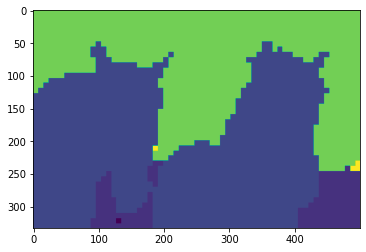

In [87]:
plt.imshow(predict[0])

In [239]:
predict

array([[[47, 47, 47, ..., 47, 47, 47],
        [47, 47, 47, ..., 47, 47, 47],
        [47, 47, 47, ..., 47, 47, 47],
        ...,
        [31, 31, 31, ..., 29, 29, 29],
        [31, 31, 31, ..., 29, 29, 29],
        [31, 31, 31, ..., 29, 29, 29]]])

In [240]:
predict.shape

(1, 333, 500)